In [1]:

####################################################################################################
####################################################################################################

import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

from IPython.display import display

sys.path.append(os.path.abspath("../python_pax_reader"))
import waveformset as wfset

from helpers import *

plt.style.use('dbarge')


In [2]:

####################################################################################################
####################################################################################################

file_raw   = "../data_xenon_waveform/FakeWaveform_raw/XENON1T-0-000000000-000000999-000001000.zip"
file_truth = "../data_xenon_waveform/FakeWaveform_truth.csv"

nEvent = 1


In [3]:

####################################################################################################
####################################################################################################

nEventsGeant = 2

wfs = wfset.WaveformSet()

wfs.read_data_and_truth(file_raw, file_truth, nEventsGeant)

df_pmts = wfs.get_waveforms_in_channels(nEvent)


100%|██████████| 1000/1000 [00:03<00:00, 288.33it/s]


Events:    2
PMT Shape: (248,)


In [4]:

####################################################################################################
# True Time Window of S2 Pulse
####################################################################################################

df_truth = wfs.truth()

df_truth = wfs.truth()[nEvent]
df_truth = df_truth.loc[df_truth['peak_type'] == 's2']

t0 = df_truth.iloc[0]['t_first_electron']
t1 = df_truth.iloc[0]['t_last_electron']

s0 = int(np.round(t0 / 10))
s1 = int(np.round(t1 / 10))

eps = (s1 - s0)*2.0
x0  = s0 - eps
x1  = s1 + eps



In [ ]:

##########################################################################################
# Plot Single PMT Waveform
##########################################################################################

df1  = df_pmts.iloc[:, 0:1].copy(deep=True)
print(df1.shape)
#display(df1)
ymax = np.amax(df1.as_matrix())    
print(ymax)

#
f = plt.figure()
plt.plot(df1, linewidth=1)
plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+50])
y0, y1 = plt.ylim()
t1 = plt.title("PMT #1 Waveform", y=1.05)

f.savefig("plots/s2_waveform_pmt001.png")


In [ ]:

##########################################################################################
# Plot Single PMT Waveforms
##########################################################################################

df_pmts = wfs.get_waveforms_in_channels(nEvent)
df_pmts = df_pmts.iloc[:, 0:127]

print(df_pmts.shape)


for i in range(0 , 127):
    
    df = df_pmts.iloc[:, i:i+1]
    
    plt.plot(df, linewidth=1)
    plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
    plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
    plt.xlim([s0-50, s1+200])
    

In [ ]:

##########################################################################################
##########################################################################################

df_pmts_s2ranked         = waveformIndexRankedByIntegral(df_pmts, s0, s1)
nSamples                 = len(df_pmts.index)
     
idxs_pmts_top127         = df_pmts_s2ranked.iloc[0:127, 0:1].as_matrix().reshape(127)
idxs_pmts_top065         = df_pmts_s2ranked.iloc[0: 65, 0:1].as_matrix().reshape(65)
idxs_pmts_top050         = df_pmts_s2ranked.iloc[0: 50, 0:1].as_matrix().reshape(50)
idxs_pmts_top030         = df_pmts_s2ranked.iloc[0: 30, 0:1].as_matrix().reshape(30)
idxs_pmts_top020         = df_pmts_s2ranked.iloc[0: 20, 0:1].as_matrix().reshape(20)
idxs_pmts_top010         = df_pmts_s2ranked.iloc[0: 10, 0:1].as_matrix().reshape(10)
idxs_pmts_top001         = df_pmts_s2ranked.iloc[0:  1, 0:1].as_matrix().reshape(1)

arr_waveform_sum127      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top127, s0, s1)
arr_waveform_sum065      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top065, s0, s1)
arr_waveform_sum050      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top050, s0, s1)
arr_waveform_sum030      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top030, s0, s1)
arr_waveform_sum020      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top020, s0, s1)
arr_waveform_sum010      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top010, s0, s1)
arr_waveform_sum001      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top001, s0, s1)

sum_s2_top127            = np.sum(arr_waveform_sum127[s0:s1])
sum_s2_top065            = np.sum(arr_waveform_sum065[s0:s1])
sum_s2_top050            = np.sum(arr_waveform_sum050[s0:s1])
sum_s2_top030            = np.sum(arr_waveform_sum030[s0:s1])
sum_s2_top020            = np.sum(arr_waveform_sum020[s0:s1])
sum_s2_top010            = np.sum(arr_waveform_sum010[s0:s1])
sum_s2_top001            = np.sum(arr_waveform_sum001[s0:s1])

arr_waveform_sum127_norm = np.divide(arr_waveform_sum127, sum_s2_top127*np.ones(nSamples)) 
arr_waveform_sum065_norm = np.divide(arr_waveform_sum065, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum050_norm = np.divide(arr_waveform_sum050, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum030_norm = np.divide(arr_waveform_sum030, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum020_norm = np.divide(arr_waveform_sum020, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum010_norm = np.divide(arr_waveform_sum010, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum001_norm = np.divide(arr_waveform_sum001, sum_s2_top127*np.ones(nSamples))

frac_s2_top127           = np.round(100*(sum_s2_top127 / sum_s2_top127), 1)
frac_s2_top065           = np.round(100*(sum_s2_top065 / sum_s2_top127), 1)
frac_s2_top050           = np.round(100*(sum_s2_top050 / sum_s2_top127), 1)
frac_s2_top030           = np.round(100*(sum_s2_top030 / sum_s2_top127), 1)
frac_s2_top020           = np.round(100*(sum_s2_top020 / sum_s2_top127), 1)
frac_s2_top010           = np.round(100*(sum_s2_top010 / sum_s2_top127), 1)
frac_s2_top001           = np.round(100*(sum_s2_top001 / sum_s2_top127), 1)


##########################################################################################
##########################################################################################

arr_s2sum_ranked  = df_pmts_s2ranked.iloc[:, 1].as_matrix().reshape(len(df_pmts_s2ranked.index), 1)
arr_s2idx_ranked  = df_pmts_s2ranked.iloc[:, 0].as_matrix().reshape(len(df_pmts_s2ranked.index), 1)
arr_s2frac_ranked = arr_s2sum_ranked / sum_s2_top127
arr_s2idx_ranked  = arr_s2idx_ranked.astype(int)


##########################################################################################
##########################################################################################

idx_pmt_rank001 = arr_s2idx_ranked[  0, 0]
idx_pmt_rank010 = arr_s2idx_ranked[  9, 0]
idx_pmt_rank050 = arr_s2idx_ranked[ 49, 0]
idx_pmt_rank075 = arr_s2idx_ranked[ 75, 0]
idx_pmt_rank100 = arr_s2idx_ranked[100, 0]

arr_waveform_rank001 = df_pmts.iloc[:, idx_pmt_rank001]
arr_waveform_rank010 = df_pmts.iloc[:, idx_pmt_rank010]
arr_waveform_rank050 = df_pmts.iloc[:, idx_pmt_rank050]
arr_waveform_rank075 = df_pmts.iloc[:, idx_pmt_rank075]
arr_waveform_rank100 = df_pmts.iloc[:, idx_pmt_rank100]

if (frac_s2_top127 != 100):
    
    print("Error in Normalizatoin!")
    
    
##########################################################################################
##########################################################################################

print()
print("S2 Integral over 127 top PMTs:\t" + str(sum_s2_top127))
print("S2 Integral over   1 top PMTs:\t" + str(sum_s2_top001))
print("S2 Fraction, top PMTs:\t\t" + str(frac_s2_top001) + " %")
print()



In [ ]:

##########################################################################################
##########################################################################################

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
plt.plot(arr_waveform_sum127, label='S2 (127 PMTs)')
#plt.plot(arr_waveform_sum065, label='S2 ( 65 PMTs)')
#plt.plot(arr_waveform_sum050, label='S2 ( 50 PMTs)')
#plt.plot(arr_waveform_sum030, label='S2 ( 30 PMTs)')
#plt.plot(arr_waveform_sum020, label='S2 ( 20 PMTs)')
plt.plot(arr_waveform_sum010, label='S2 ( 10 PMTs)')
plt.plot(arr_waveform_sum001, label='S2 (  1 PMT )')

plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
plt.title('S2 Waveform Summed Over PMTs', y=1.05)
plt.xlabel('sample (10 ns)')
plt.ylabel('ADC Counts')
plt.xlim([s0-100, s1+500])
plt.legend(fontsize=16)

#
ax2 = plt.subplot(1, 2, 2)
plt.plot(arr_waveform_sum127_norm, label='S2 (127 PMTs)')
#plt.plot(arr_waveform_sum065_norm, label='S2 ( 65 PMTs)')
#plt.plot(arr_waveform_sum050_norm, label='S2 ( 50 PMTs)')
#plt.plot(arr_waveform_sum030_norm, label='S2 ( 30 PMTs)')
#plt.plot(arr_waveform_sum020_norm, label='S2 ( 20 PMTs)')
plt.plot(arr_waveform_sum010_norm, label='S2 ( 10 PMTs)')
plt.plot(arr_waveform_sum001_norm, label='S2 (  1 PMT )')
plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
plt.title('Normalized S2 Waveform Summed over PMTs', y=1.05)
plt.xlabel('sample (10 ns)')
plt.xlim([s0-100, s1+500])
plt.legend(fontsize=16)

f.savefig("plots/s2_summed_waveforms.png")
plt.close()

print()
display(f)
print()



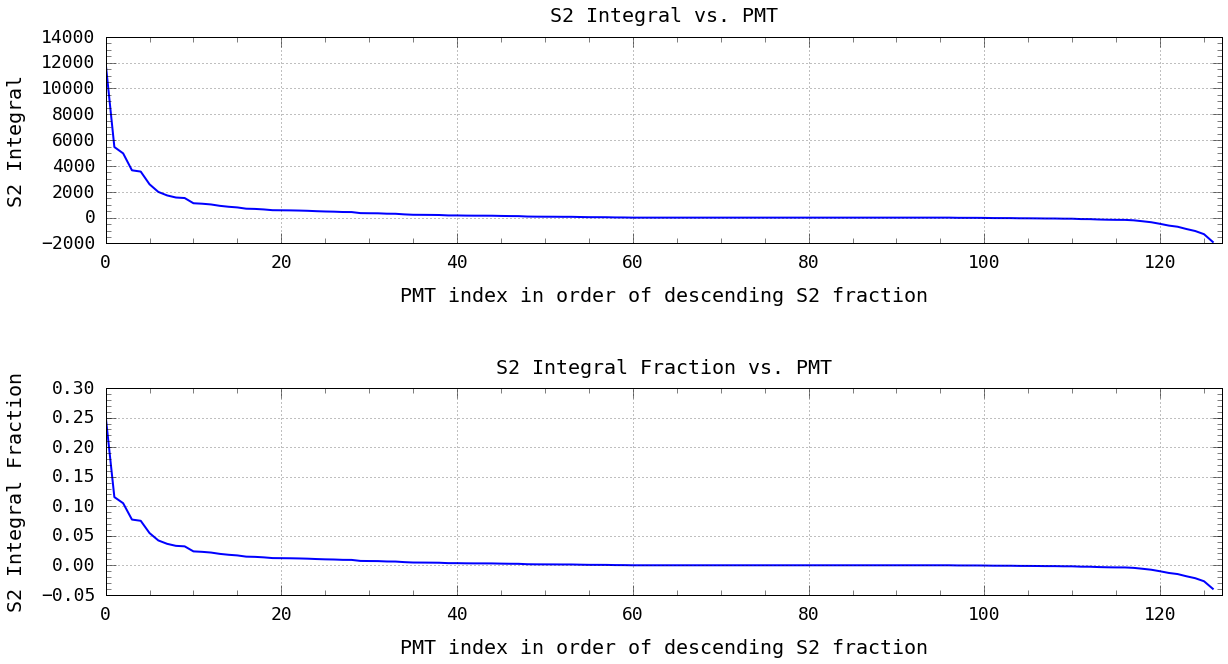

In [25]:

##########################################################################################
# Plot the S2 contribution per PMT
##########################################################################################

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.7)

ax1 = plt.subplot(2, 1, 1)
plt.plot(arr_s2sum_ranked)
plt.xlim([0, 127])
plt.xlabel('PMT index in order of descending S2 fraction')
plt.ylabel('S2 Integral')
plt.title('S2 Integral vs. PMT', y=1.05)

ax2 = plt.subplot(2, 1, 2)
plt.plot(arr_s2frac_ranked)
plt.xlim([0, 127])
plt.xlabel('PMT index in order of descending S2 fraction')
plt.ylabel('S2 Integral Fraction')
plt.title('S2 Integral Fraction vs. PMT', y=1.05)

f.savefig("plots/s2_integral_vs_pmt.png")
plt.close()

print()
display(f)
print()


In [ ]:

##########################################################################################
# Facet Grid
##########################################################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [ ]:

##########################################################################################
# Sanity
##########################################################################################

sum_waveforms = wfs.waveforms_in_channels[nEvent].drop("event_number", axis=1).iloc[:, 0:127].sum(axis=1).as_matrix()
sum_s2_all    = np.sum(sum_waveforms[s0:s1])

plt.plot(sum_waveforms      , color='b')
plt.plot(arr_waveform_sum127, color='y')
plt.xlim([s0-100, s1+500])

In [ ]:

##########################################################################################
# Debug Uncorrected Waveforms
##########################################################################################

#df_pmts = wfs.get_waveforms_in_channels(nEvent)
#df      = df_pmts.iloc[:, 0:1].copy(deep=True)
#    
#fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
#
##
#plt.subplot(2, 2, 1)
#ax1 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+200])
#t1 = plt.title("Single PMT Waveform", y=1.05)
#
##
#df.replace(0.0, 16000, inplace=True)
#df -= 16000
#
#plt.subplot(2, 2, 2)
#ax2 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+200])
#t2 = plt.title("Single PMT Waveform, Pedestal Subtracted (16000 ADC)", y=1.05)
#
##
#df *= -1

#plt.subplot(2, 2, 3)
#ax2 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+200])
#t3 = plt.title("Single PMT Waveform, Inverted, Pedestal Subtracted", y=1.05)
#
##
#plt.subplot(2, 2, 4)
#ax2 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0+75, s1-10])
#plt.ylim([-20, 60])
#t4 = plt.title("Single PMT Waveform Corrected Zoom", y=1.05)

#fig.savefig("plots/s2_single_pmt_waveform_bug.png")